In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip "/content/drive/My Drive/Colab_Files/FMD.zip" -d FMD

Archive:  /content/drive/My Drive/Colab_Files/FMD.zip
   creating: FMD/mask/
   creating: FMD/mask/fabric/
  inflating: FMD/mask/fabric/fabric_moderate_001_new.jpg  
  inflating: FMD/mask/fabric/fabric_moderate_002_new.jpg  
  inflating: FMD/mask/fabric/fabric_moderate_003_new.jpg  
  inflating: FMD/mask/fabric/fabric_moderate_004_new.jpg  
  inflating: FMD/mask/fabric/fabric_moderate_005_new.jpg  
  inflating: FMD/mask/fabric/fabric_moderate_006_new.jpg  
  inflating: FMD/mask/fabric/fabric_moderate_007_new.jpg  
  inflating: FMD/mask/fabric/fabric_moderate_008_new.jpg  
  inflating: FMD/mask/fabric/fabric_moderate_009_new.jpg  
  inflating: FMD/mask/fabric/fabric_moderate_010_new.jpg  
  inflating: FMD/mask/fabric/fabric_moderate_011_new.jpg  
  inflating: FMD/mask/fabric/fabric_moderate_012_new.jpg  
  inflating: FMD/mask/fabric/fabric_moderate_013_new.jpg  
  inflating: FMD/mask/fabric/fabric_moderate_014_new.jpg  
  inflating: FMD/mask/fabric/fabric_moderate_015_new.jpg  
  inflat

In [3]:
!ls FMD -lah

total 16K
drwxr-xr-x  4 root root 4.0K Nov 10 13:27 .
drwxr-xr-x  1 root root 4.0K Nov 10 13:27 ..
drwxr-xr-x 12 root root 4.0K Nov 20  2009 image
drwxr-xr-x 12 root root 4.0K Jun  8  2010 mask


In [4]:
!nvidia-smi

Tue Nov 10 13:27:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [6]:
import pathlib

data_dir = pathlib.Path("FMD/image")

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1000


100


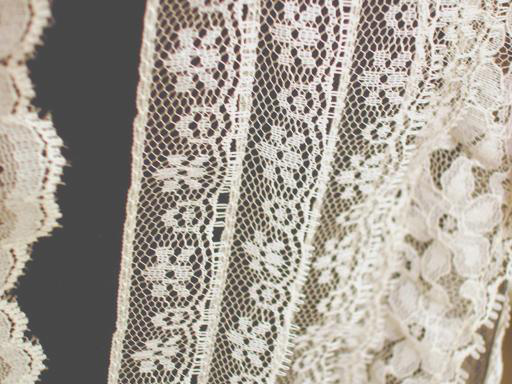

In [7]:
fabrics = list(data_dir.glob('fabric/*.jpg'))
print(len(fabrics))
PIL.Image.open(str(fabrics[0]))

In [44]:
batch_size = 32
img_height = 299
img_width = 299

In [45]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1000 files belonging to 10 classes.
Using 800 files for training.


In [46]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1000 files belonging to 10 classes.
Using 200 files for validation.


In [47]:
class_names = train_ds.class_names
print(class_names)

['fabric', 'foliage', 'glass', 'leather', 'metal', 'paper', 'plastic', 'stone', 'water', 'wood']


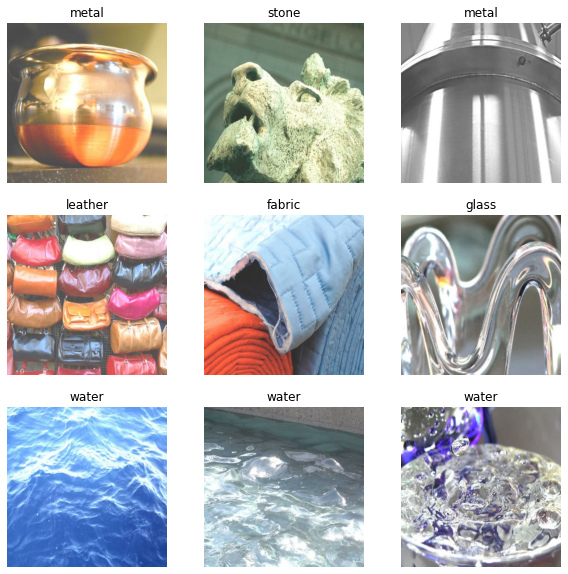

In [48]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [49]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 299, 299, 3)
(32,)


**Configure the dataset for performance** ([link](https://www.tensorflow.org/tutorials/images/classification#configure_the_dataset_for_performance))



In [50]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE) # shuffle can be less than dataset size
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [51]:
preprocess_input = keras.applications.inception_v3.preprocess_input

In [54]:
base_model = keras.applications.InceptionV3(include_top=False, input_shape=(img_height, img_width, 3))

In [55]:
# don't train base model weights
base_model.trainable = False

In [56]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 149, 149, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 149, 149, 32) 96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 149, 149, 32) 0           batch_normalization_188[0][0]    
_______________________________________________________________________________________

In [57]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 8, 8, 2048)


In [58]:
global_average_layer = keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [59]:
prediction_layer = tf.keras.layers.Dense(10)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 10)


In [60]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

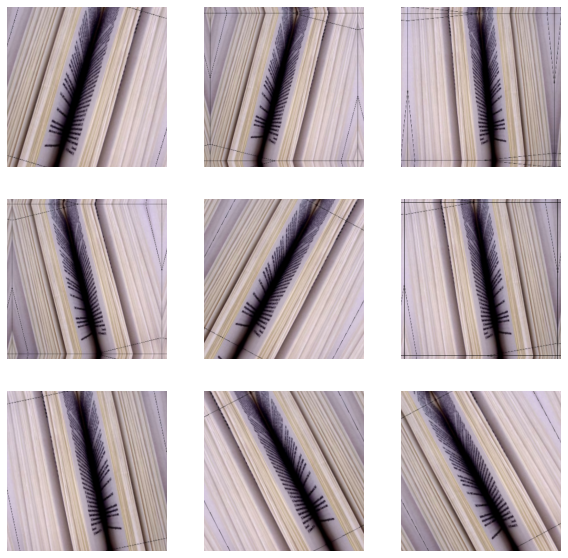

In [61]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [62]:
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [63]:
base_learning_rate = 0.0001
optimizer = keras.optimizers.Adam(lr=base_learning_rate)
loss= keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])

In [64]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 299, 299, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv_1 (Tenso [(None, 299, 299, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub_1 (TensorFlo [(None, 299, 299, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)             

In [65]:
# trainable parameters in the Dense layer divided between two tf.Variable objects, the weights and biases.
len(model.trainable_variables)

2

In [66]:
no_epochs = 100

In [67]:
loss0, accuracy0 = model.evaluate(val_ds)

7/7 [==============================] - 1s 98ms/step - loss: 2.4589 - accuracy: 0.0750


In [68]:
history = model.fit(train_ds,
                    epochs=no_epochs,
                    validation_data=val_ds)

Epoch 1/100
25/25 [==============================] - 4s 167ms/step - loss: 2.4768 - accuracy: 0.0900 - val_loss: 2.3326 - val_accuracy: 0.1250
Epoch 2/100
25/25 [==============================] - 4s 169ms/step - loss: 2.2937 - accuracy: 0.1488 - val_loss: 2.2177 - val_accuracy: 0.1850
Epoch 3/100
25/25 [==============================] - 4s 170ms/step - loss: 2.1800 - accuracy: 0.2150 - val_loss: 2.1101 - val_accuracy: 0.2550
Epoch 4/100
25/25 [==============================] - 4s 170ms/step - loss: 2.0549 - accuracy: 0.2600 - val_loss: 2.0055 - val_accuracy: 0.3450
Epoch 5/100
25/25 [==============================] - 4s 172ms/step - loss: 1.9407 - accuracy: 0.3450 - val_loss: 1.9140 - val_accuracy: 0.4200
Epoch 6/100
25/25 [==============================] - 4s 173ms/step - loss: 1.8337 - accuracy: 0.3975 - val_loss: 1.8196 - val_accuracy: 0.4700
Epoch 7/100
25/25 [==============================] - 4s 174ms/step - loss: 1.7724 - accuracy: 0.4412 - val_loss: 1.7379 - val_accuracy: 0.5250

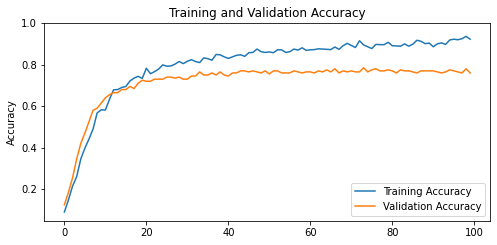

In [69]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.show()

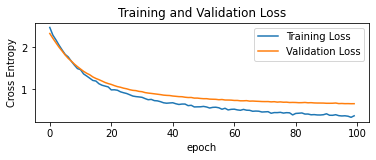

In [70]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [71]:
loss1, accuracy1 = model.evaluate(val_ds)

7/7 [==============================] - 1s 95ms/step - loss: 0.6565 - accuracy: 0.7600
